In [1]:
import os; 
import pandas as pd; pd.set_option('mode.chained_assignment',None)
from pandas.plotting import register_matplotlib_converters; register_matplotlib_converters()
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import re
import xlrd
import statistics as stat
from xlsxwriter.utility import xl_rowcol_to_cell
from random import sample
from pandas.plotting import register_matplotlib_converters

from src.data_models.SmartsCsvDataModel import SmartsCsvDataModel
from src.data_models.smartshelper import metrics, fixNum, unSMART, cparty, wtf, textfunc, identities
from src.data_models.SmartsDataModel import SmartsDataModel
from src.utility.DataModelUtility import execute_query_data_frame
from src.data_models.SmartsDataModel import SmartsDataModel
from src.data_models.UPMhelper import UPMalerts

alerting_1 = datetime.date(2019,8,1)
alerting_2 = datetime.date(2019,8,31)

/Users/sqian/.pyenv/versions/3.7.0/envs/env_370/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
alerts0 = fixNum(unSMART(pd.read_excel('~/Documents/vmfldr/smarts1_2019Aug.xlsx'))).rename(columns={'InstrumentName':'InstrumentCode'})

-> type fixed, kept 179 rows, 12 columns


In [3]:
regexline = '.+Broker\D+([\d]+).+Broker\D+([\d]+).+'

alerts4045 = alerts0.loc[alerts0['AlertCode'] == 4045].reset_index()
alerts4045[['acc1','acc2']] = alerts4045['LongText'].str.extract(regexline).astype(int)
alerts4045set = alerts4045[['Date','InstrumentCode','acc1','acc2']]
alerts4045set

,Date,InstrumentCode,acc1,acc2
0,2019-08-02,LTCETH,44498,1507866
1,2019-08-07,LTCETH,44498,1507866


In [4]:
# collusionlist = pd.concat([alerts4045set['acc1'],alerts4045set['acc2']], axis=0).tolist()
# idee = identities(collusionlist,alerting_1,alerting_2)

In [5]:
# for i in range(0,len(idee)): print(idee.iloc[i]['text'])

In [6]:
# alerts4045['LongText'][0]

In [7]:
def plotNet(i):

    ### Set Variables
    aclist = tuple(alerts4045[['acc1','acc2']].reset_index(drop=True).iloc[i].tolist())
    symbol = alerts4045['InstrumentCode'][i]
    date = alerts4045['Date'][i].to_pydatetime()
    mainacc = alerts4045['acc1'][i]
    otheracc = alerts4045['acc2'][i]
    
    ### Collect Data
    query = """
            SELECT event_id, created::date, account_id, side, quantity
            from order_fill_event
            where created::date between '{t1}' and '{t2}' and account_id in {x} and trading_pair = '{y}'
            order by event_id
            """.format(t1 = alerting_1.strftime("%Y%m%d"), 
                       t2 = alerting_2.strftime("%Y%m%d"), 
                       x=aclist,
                       y = symbol)
    dataC = execute_query_data_frame(query, 'engine')

    query = """
        SELECT created::date, account_id, trading_pair, side, sum(quantity)
        from order_fill_event
        where created::date between '{t1}' and '{t2}' and account_id in {x} and trading_pair = '{y}'
        group by created::date, account_id, trading_pair, side
        """.format(t1 = alerting_1.strftime("%Y%m%d"), 
                   t2 = alerting_2.strftime("%Y%m%d"), 
                   x=aclist,
                   y = symbol)
    dataD = execute_query_data_frame(query, 'engine')

    query = """
            SELECT exchange_account_id as account_id, user_or_account_name, is_institutional
            from account_derived_metadata
            where exchange_account_id in {x}
            """.format(x=aclist)
    dataE = execute_query_data_frame(query, 'engine')

    ### Collect Data
    query = """
        SELECT side, created::date, trading_pair, sum(quantity)
        from order_fill_event
        where created::date between '{t1}' and '{t2}' and trading_pair = '{y}'
        group by trading_pair, side, created::date
        """.format(t1 = alerting_1.strftime("%Y%m%d"), 
                   t2 = alerting_2.strftime("%Y%m%d"), 
                   y = symbol)
    dataF = execute_query_data_frame(query, 'engine')

    ### Data Prep & Metrics
    datagb = dataC.groupby('event_id')
    eventsumm = pd.DataFrame(datagb['account_id'].apply(pd.unique).apply(lambda x: sorted(x))).reset_index().rename(columns={'account_id':'pair'})
    eventsumm2 = eventsumm.loc[eventsumm['pair'].apply(len) == 2]
    eventsumm2['account_id'] = mainacc 
    eventsumm3 = pd.concat([eventsumm2.set_index(['event_id','account_id']),dataC.set_index(['event_id','account_id'])],join='inner', axis=1)
    eventsumm3['quantitySide'] = eventsumm3['quantity'] * (2 * (eventsumm3['side'] == 'buy') - 1)
    eventsumm4 = eventsumm3.groupby('created')[['quantity','quantitySide']].sum()
    eventsumm4['Net'] = eventsumm4['quantitySide']/eventsumm4['quantity']


    ### Date Plot Net Volume % by Day
    plt.rcParams['figure.figsize'] = (12,4)
    plotdata = pd.DataFrame(eventsumm4['Net'])
    plt.plot_date(x=plotdata.index, y=plotdata['Net'], fmt="-o", xdate=True)
    plt.plot_date(x=plotdata.index, y=plotdata['Net']*0, fmt="-", xdate=True,color='black')
    plt.axvline(date, color = 'green')
    plt.ylim(-1.1,1.1)
    plt.xlim(alerting_1-datetime.timedelta(days=1), alerting_2+datetime.timedelta(days=1))
    plt.ylabel("Net Volume % [(+) = buy / (-) = sell]")
    plt.grid(True)
    plt.xticks(rotation=20)
    plt.title("Figure 1:  Net Volume as % of Traded Volume \n on {} Traded Between Accounts {} from POV {}".format(symbol,aclist,aclist[0]))
    plt.show()


    ### Plot Activity During Alerting Period
    plotdata0 = pd.pivot_table(dataD,index='created',columns=['account_id','side'],values='sum').fillna(0)
    plotdata3 = pd.DataFrame(plotdata0[mainacc])
    plt.plot_date(x=plotdata3.index, y=plotdata3['buy'], fmt="b-o", xdate=True)
    plt.plot_date(x=plotdata3.index, y=-plotdata3['sell'], fmt="r-o", xdate=True)
    plt.axvline(date, color = 'green')
    plt.xlim(alerting_1-datetime.timedelta(days=1), alerting_2+datetime.timedelta(days=1))
    plt.ylabel("Volume in Units")
    plt.grid(True)
    plt.xticks(rotation=20)
    plt.title("Figure 2:  Traded Volume in Units of {} by {}".format(symbol,mainacc))
    plt.show()

    plotdata3 = pd.DataFrame(plotdata0[otheracc])
    plt.plot_date(x=plotdata3.index, y=plotdata3['buy'], fmt="b-o", xdate=True)
    plt.plot_date(x=plotdata3.index, y=-plotdata3['sell'], fmt="r-o", xdate=True)
    plt.axvline(date, color = 'green')
    plt.xlim(alerting_1-datetime.timedelta(days=1), alerting_2+datetime.timedelta(days=1))    
    plt.ylabel("Volume in Units")
    plt.grid(True)
    plt.xticks(rotation=20)
    plt.title("Figure 3:  Traded Volume in Units of {} by {}".format(symbol,otheracc))
    plt.show()

    plotdata0 = pd.pivot_table(dataF,index='created',columns=['side'],values='sum').fillna(0)
    plotdata3 = pd.DataFrame(plotdata0)
    plt.plot_date(x=plotdata3.index, y=plotdata3['buy'], fmt="b-o", xdate=True)
    plt.plot_date(x=plotdata3.index, y=-plotdata3['sell'], fmt="r-o", xdate=True)
    plt.axvline(date, color = 'green')
    plt.ylabel("Volume in Units")
    plt.xlim(alerting_1-datetime.timedelta(days=1), alerting_2+datetime.timedelta(days=1))    
    plt.grid(True)
    plt.xticks(rotation=20)
    plt.title("Figure 4:  Daily {} Volume".format(symbol))
    plt.show()

    accc0 = round(pd.DataFrame(dataD.groupby(['account_id','side']).sum()['sum'])/1000,2).rename(columns={'sum':'sumThousands'})
    accc1 = pd.pivot_table(accc0,columns='side',index='account_id',values='sumThousands')
    accc2 = pd.concat([dataE.set_index('account_id'),accc1],axis=1)

INFO:root:Constructing Singleton
INFO:root:Using global configuration /Users/sqian/msv.yaml.
INFO:root:Completed loading configuration.
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.957878


INFO:root:Loaded dataframe with 251 rows in 0:00:05.724045.
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.679100


INFO:root:Loaded dataframe with 59 rows in 0:00:03.564065.
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.622800


INFO:root:Loaded dataframe with 2 rows in 0:00:01.031433.
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.674304


INFO:root:Loaded dataframe with 58 rows in 0:00:13.123036.


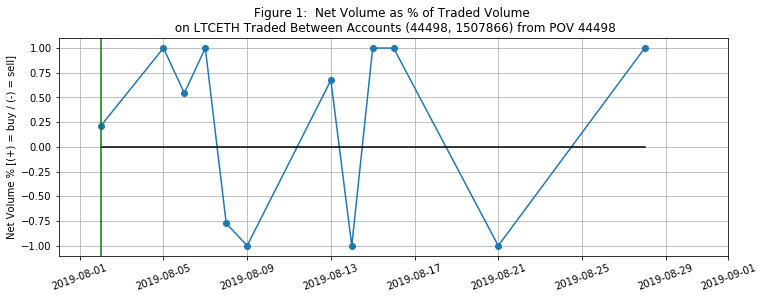

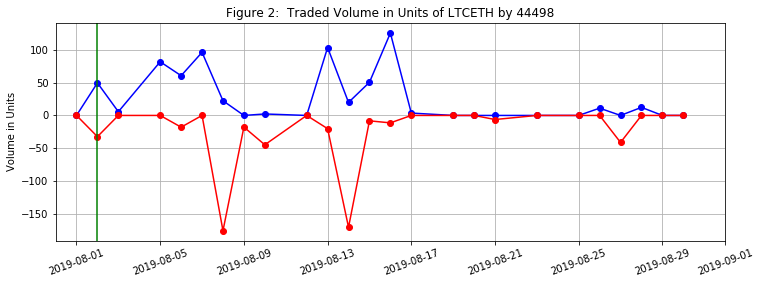

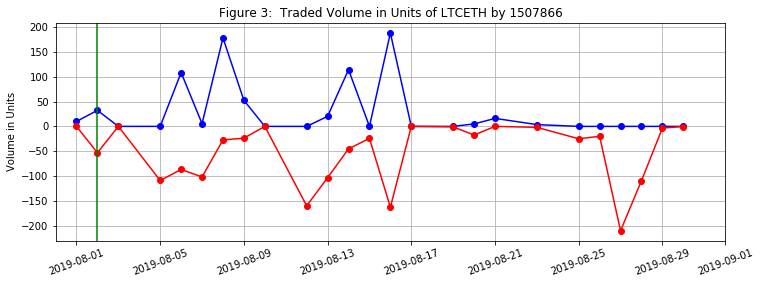

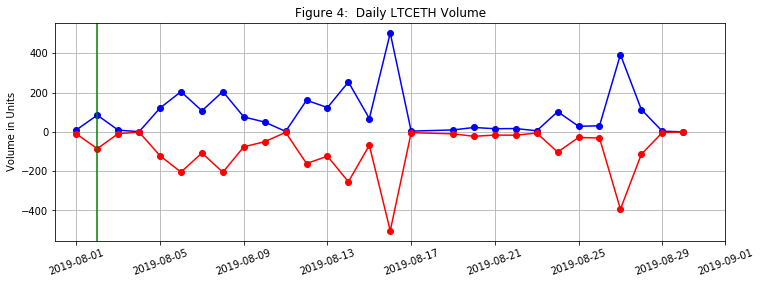

In [8]:
plotNet(0)

INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:02.376599


INFO:root:Loaded dataframe with 251 rows in 0:00:05.393621.
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.675000


INFO:root:Loaded dataframe with 59 rows in 0:00:03.908939.
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.636468


INFO:root:Loaded dataframe with 2 rows in 0:00:00.885964.
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.4p1)
INFO:paramiko.transport:Authentication (publickey) successful!


ssh_connect 0:00:00.799974


INFO:root:Loaded dataframe with 58 rows in 0:00:12.677859.


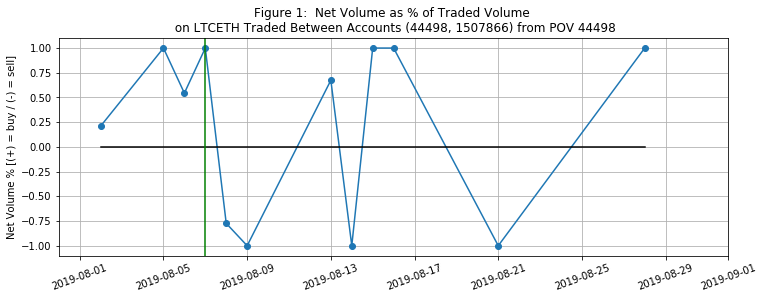

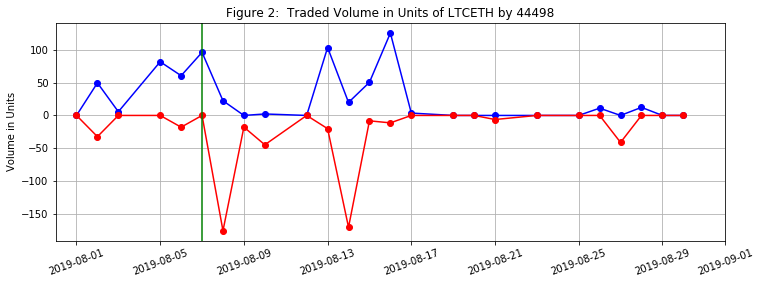

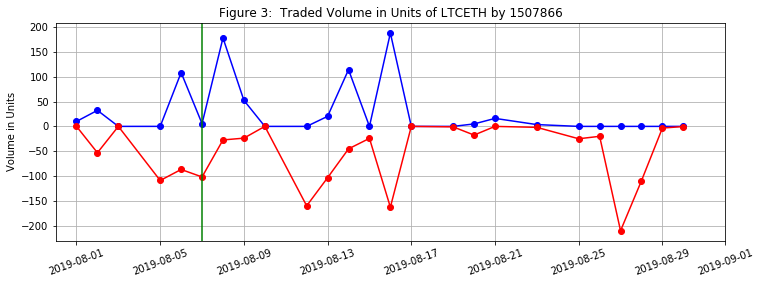

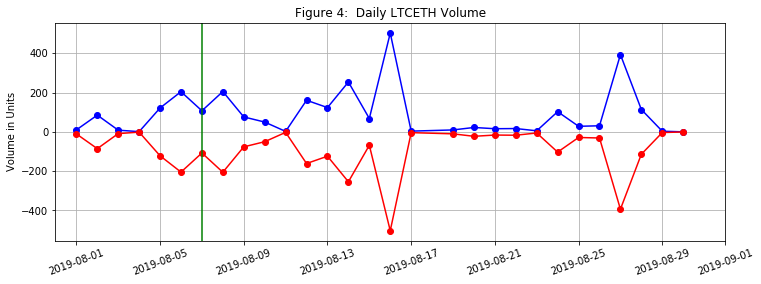

In [9]:
plotNet(1)